In [84]:
import pandas as pd
import numpy as np

In [85]:
df = pd.read_csv('city_united.csv', sep=',')

In [86]:
df.head()

,UA_Name,UA_Country,UA_Continent,Housing,Cost of Living,Startups,Venture Capital,Travel Connectivity,Commute,Business Freedom,...,Healthcare,Education,Environmental Quality,Economy,Taxation,Internet Access,Leisure & Culture,Tolerance,Outdoors,Quality of Life Index
0,Adelaide,Australia,Oceania,6.3095,4.692,3.1365,2.640,1.7765,5.33625,9.399667,...,7.936667,5.1420,8.33075,6.0695,4.5885,4.3410,4.3285,7.8220,5.5310,200.03
1,Raleigh,North Carolina,North America,6.1285,5.610,5.4970,5.157,1.7570,4.78425,8.671000,...,6.677333,7.1165,8.58375,6.5145,4.0620,7.9515,6.6130,7.5620,3.3905,197.30
2,Zurich,Switzerland,Europe,1.4730,1.000,6.2035,3.872,7.7335,5.83950,8.888000,...,7.670333,7.2875,8.64300,6.5520,6.4285,7.2675,4.9655,8.7845,5.4010,194.41
3,Wellington,New Zealand,Oceania,5.1345,5.161,2.4715,1.753,0.8525,6.03975,10.000000,...,8.078333,4.7560,9.60925,5.5055,5.9315,5.1745,4.5990,8.1160,6.3970,193.89
4,Charlotte,North Carolina,North America,5.5490,4.987,6.2480,2.878,3.6790,4.13400,8.671000,...,6.432333,3.6245,8.00925,6.5145,4.0620,6.3870,5.6060,6.7895,1.3115,193.30


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UA_Name                187 non-null    object 
 1   UA_Country             187 non-null    object 
 2   UA_Continent           187 non-null    object 
 3   Housing                187 non-null    float64
 4   Cost of Living         187 non-null    float64
 5   Startups               187 non-null    float64
 6   Venture Capital        187 non-null    float64
 7   Travel Connectivity    187 non-null    float64
 8   Commute                187 non-null    float64
 9   Business Freedom       187 non-null    float64
 10  Safety                 187 non-null    float64
 11  Healthcare             187 non-null    float64
 12  Education              187 non-null    float64
 13  Environmental Quality  187 non-null    float64
 14  Economy                187 non-null    float64
 15  Taxati

Пустых ячеек нет, проверим на наличие дубикатов.

In [88]:
df.duplicated().sum()    # дубликатов нет

0

### 1. Определения факторов.

Все факторы, кроме первых трех столбцов являются количественными. Проверим на наличие выбросов в них и нормализуем данные.

In [89]:
import seaborn as sns

<AxesSubplot:>

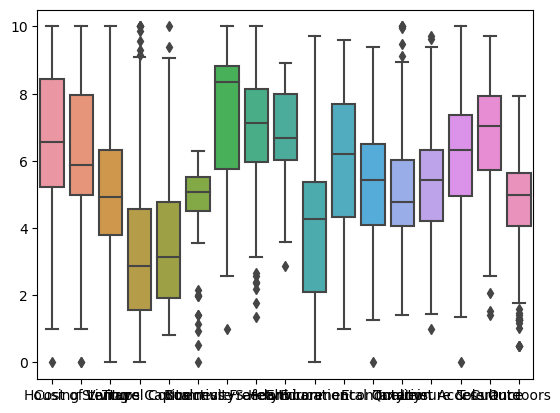

In [90]:
sns.boxplot(data=df[df.columns[:-1]])

In [91]:
x = df[df.columns[3:-1]].copy()
y = df[df.columns[-1]].copy()

In [92]:
x_c = list(x.columns)

In [93]:
# имеются выбросы удалим их по межквартильному размаху:
for c in x_c:
    q3 = df[c].describe()['75%']    # 75-ая квантиль
    q1 = df[c].describe()['25%']    # 25-ая квантиль
    iqr = q3-q1    # длина промежутка
    iqr_min = q1 - 1.5 * iqr    # нижняя граница
    iqr_max = q3 + 1.5 * iqr    # верхняя граница
    df = df[(iqr_min <= df[c]) & (df[c] <= iqr_max)]    # перезаписываем датасет без выбросов

<AxesSubplot:>

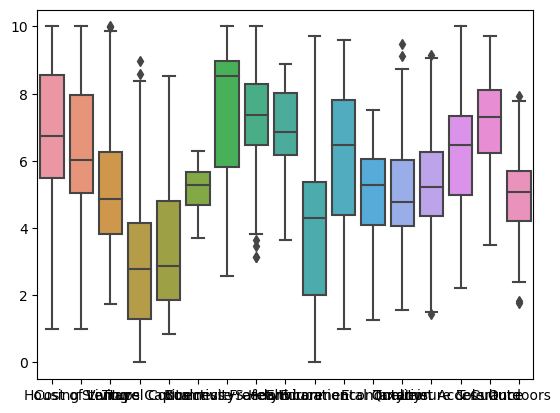

In [94]:
sns.boxplot(data=df[df.columns[:-1]])

Было удалено 53 строки, выбросок стало визуально меньше.

In [95]:
# стандартизируем данные с факторами:
from sklearn.preprocessing import StandardScaler

In [96]:
scaler = StandardScaler()
x_st = scaler.fit_transform(x)

<AxesSubplot:ylabel='Count'>

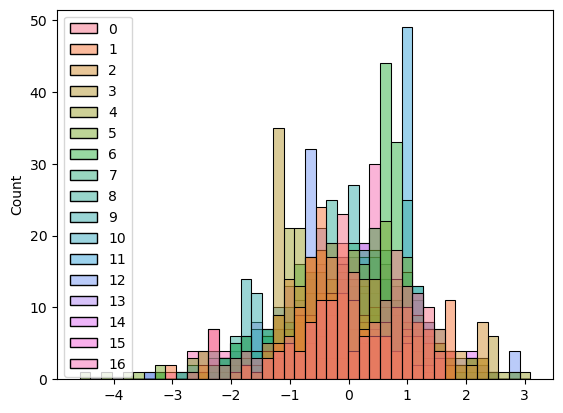

In [97]:
sns.histplot(x_st)

In [98]:
# разделим выборку на тестовую и тренировочную:
from sklearn.model_selection import train_test_split

In [99]:
x_train, x_test, y_train, y_test = train_test_split(x_st, y, test_size=0.2, random_state=40)

### 2. Построение моделей.

In [100]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Линейная

In [101]:
lin_model = LinearRegression()
# переменные были определены выше:
lin_model.fit(x_train, y_train)
y_pred = lin_model.predict(x_test)
r2_lin = r2_score(y_test, y_pred)
print("Коэффициент детерминации (R^2):", r2_lin)

Коэффициент детерминации (R^2): 0.804244823358635


Гипербола

In [102]:
hip_model = LinearRegression()
x_hip = 1 / x_st    # независимые переменные
# зависимая переменная остается такой же
x_train, x_test, y_train, y_test = train_test_split(x_hip, y, test_size=0.2, random_state=40)
hip_model.fit(x_train, y_train)
y_pred = hip_model.predict(x_test)
r2_hip = r2_score(y_test, y_pred)
print("Коэффициент детерминации (R^2):", r2_hip)

Коэффициент детерминации (R^2): -0.42305175881595725


Полулогарифмическую модель построить не получится, так как при стандартизации получились отрицательные значения "иксов", удалив которые мы значительно уменьшим объем выборки.

Покаталеьная

In [103]:
(y < 0).sum()

0

In [104]:
pok_model = LinearRegression()
x_pok = x_st    # независимые переменные
y_pok = np.log(y)    # зависимая переменная
x_train, x_test, y_train, y_test = train_test_split(x_pok, y_pok, test_size=0.2, random_state=40)
pok_model.fit(x_train, y_train)
y_pred = pok_model.predict(x_test)
r2_pok = r2_score(y_test, y_pred)
print("Коэффициент детерминации (R^2):", r2_pok)

Коэффициент детерминации (R^2): 0.7186525678786387


Степенную модель так же не удастся построить из-за отрицательности некоторых значений, невозможно вычислить их логарифм.

Парабола

In [115]:
x_p = x_st ** 2
x_par = np.array(np.concatenate((x_st, x_p), axis=1)) # независимые переменные
par_model = LinearRegression()
y_par = y    # зависимая переменная
x_train, x_test, y_train, y_test = train_test_split(x_par, y_par, test_size=0.2, random_state=40)
pok_model.fit(x_train, y_train)
y_pred = pok_model.predict(x_test)
r2_par = r2_score(y_test, y_pred)
print("Коэффициент детерминации (R^2):", r2_par)

Коэффициент детерминации (R^2): 0.8097770472392614


Итак, самый высокий коэффициент детерминации у параболической модели, соответсвенно булем считать ее лучшей.
Параболическая модель в общем виде выглядит следующим образом:

y = b0 * x_1 + ... + bn * x_n + c1 * x_1 ^ 2 + ... + cn * x_n ^ 2 + E, где 
Е - случайная ошибка